In [1]:
# To support both python 2 and python 3
# from __future__ import division, print_function, unicode_literals

import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/corelibs/src/tools-python"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes/datatypes_python"))

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

In [2]:
# Open monolithic and iterate frames
dataset_path = "/workspace/data/pose-prediction-odometry/"
RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])
print("Finished reading",len(RO_timestamps),"poses.")

reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 479 poses.


In [437]:
dim1_data = np.zeros(len(RO_timestamps))
dim2_data = np.zeros(len(RO_timestamps))
dim3_data = np.zeros(len(RO_timestamps))

for i in range(len(RO_timestamps)):
    dim1_data[i] = RO_se3s[i][0,3]
    dim2_data[i] = RO_se3s[i][1,3]
    dim3_data[i] = np.arccos(RO_se3s[i][0,0])

In [438]:
num_features = 3
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

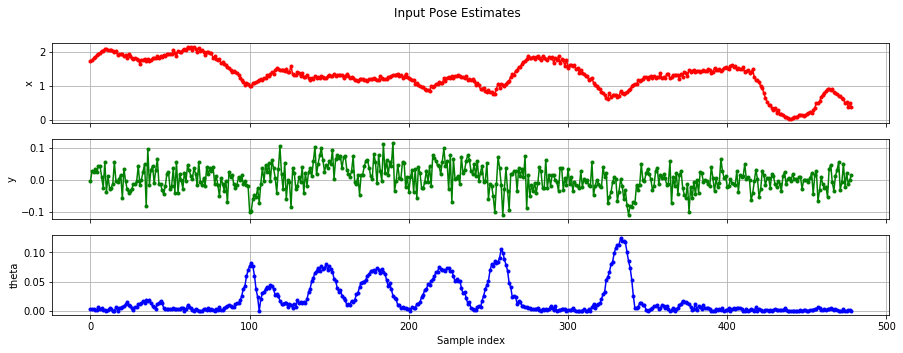

In [439]:
use_toy_data = False

if(use_toy_data):
    # Creating the artificial dataset
    dim1_data = np.arange(0,5.2,0.1)
    dim2_data = np.arange(0,0.52,0.01)
    dim3_data = np.arange(0,0.052,0.001)

    for i in range(len(dim1_data)):
        dim1_data[i] += np.random.randn()*0.2
        dim2_data[i] += np.random.randn()*0.02
        dim3_data[i] += np.random.randn()*0.002

dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [440]:
class Data2d(Dataset):   
    # Constructor
    def __init__(self):
        x_data = torch.tensor(dim1_data_scaled)
        y_data = torch.tensor(dim2_data_scaled)
        theta_data = torch.tensor(dim3_data_scaled)
        
        # input tensor holds x, y, and theta data in frame 1, frame 2
        # [x1,y1,th1,x2,y2,th2]
        # These are offset, so that x1 goes up until the second last frame
        # (current frame is treated as future prediction)
        self.x = torch.zeros(len(dim1_data)-num_frames,input_size)
        self.x[:,5] = theta_data[:-2]
        self.x[:,4] = y_data[:-2]
        self.x[:,3] = x_data[:-2]
        self.x[:,2] = theta_data[1:-1]
        self.x[:,1] = y_data[1:-1]
        self.x[:,0] = x_data[1:-1]
        
        # output tensor holds single frame, for x, y, and theta values
        # This is cropped to exclude the first n frames (n=2 here) and run up until the end
        # So a synthesised 'future' value to aim for
        self.y = torch.zeros(len(dim1_data)-num_frames,output_size)
        self.y[:,0] = x_data[2:]
        self.y[:,1] = y_data[2:]
        self.y[:,2] = theta_data[2:]
        
        self.len = self.x.shape[0]
    
    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Getting the lengthdd
    def __len__(self):
        return self.len
# Instantiation of the class  
my_data = Data2d()

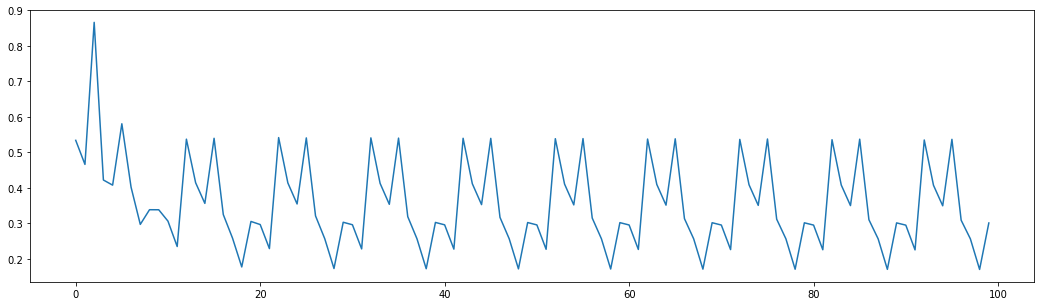

In [441]:
# Creating a linear regression model
class lin_reg(nn.Module):

    def __init__(self, in_feat, out_feat):
        super(lin_reg, self).__init__()
        self.linear = nn.Linear(in_feat, out_feat)
        
    def forward(self,x):
        yhat = self.linear(x)
        return yhat
    
# Instantiation of an object
model = lin_reg(input_size,output_size)
# print("The parameters: ", model.state_dict())

# Parameters
criterion = nn.MSELoss()

# Real data
# optimizer = optim.SGD(model.parameters(), lr = 0.01) 
# trainloader = DataLoader(dataset = my_data, batch_size = 20)

# Toy data
optimizer = optim.SGD(model.parameters(), lr = 0.3) 
trainloader = DataLoader(dataset = my_data, batch_size = 50)

# Training the model
Loss = []  # variable for storing losses after each epoch
epochs = 10

def train_model(epochs):
    for epoch in range(epochs):
        for x,y in trainloader:
            yhat = model(x)
            loss = criterion(yhat,y)
            Loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
# Calling the training function          
train_model(epochs)
plt.figure(figsize=(18,5))
plt.plot(Loss)

In [442]:
# query_dim1 = np.array([3.2,3.1])
# query_dim2 = np.array([0.032,0.031]) #np.array([0.32,0.31])
# query_dim3 = np.array([0.032,0.031])

# Prediction frame, just for sanity checking (not proper testing)
idx = 40
query_dim1 = np.array([dim1_data[idx-1],dim1_data[idx-2]])
query_dim2 = np.array([dim2_data[idx-1],dim2_data[idx-2]])
query_dim3 = np.array([dim3_data[idx-1],dim3_data[idx-2]])

print(query_dim1)
print(query_dim2)
print(query_dim3)

scaled_query_dim1 = (query_dim1 - dim1_data.mean())/dim1_data.std()
scaled_query_dim2 = (query_dim2 - dim2_data.mean())/dim2_data.std()
scaled_query_dim3 = (query_dim3 - dim3_data.mean())/dim3_data.std()

# Build combination so x, y, and theta are adjacent for 1 pose
c = np.empty(scaled_query_dim1.size + scaled_query_dim2.size + scaled_query_dim3.size)
c[0::num_features] = scaled_query_dim1
c[1::num_features] = scaled_query_dim2
c[2::num_features] = scaled_query_dim3

new_query = Variable(torch.Tensor([c]))
print(new_query)

answer = model(new_query)
print('\n raw answer:\n',answer)
print('\n scaled up again:')
print((answer[0][0]*dim1_data.std() + dim1_data.mean()).data)
print((answer[0][1]*dim2_data.std() + dim2_data.mean()).data)
print((answer[0][2]*dim3_data.std() + dim3_data.mean()).data)
print('True answer:',dim1_data[idx],dim2_data[idx],dim3_data[idx])

[1.80475844 1.76314691]
[0.04392496 0.03160922]
[0.00799972 0.01448801]
tensor([[ 1.1251,  1.0266, -0.4820,  1.0357,  0.7082, -0.2458]])

 raw answer:
 tensor([[ 1.0586,  0.3427, -0.3788]], grad_fn=<AddmmBackward>)

 scaled up again:
tensor(1.7738)
tensor(0.0175)
tensor(0.0108)
True answer: 1.8151265410403612 -0.009666116166800118 0.006278273328810045
